In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

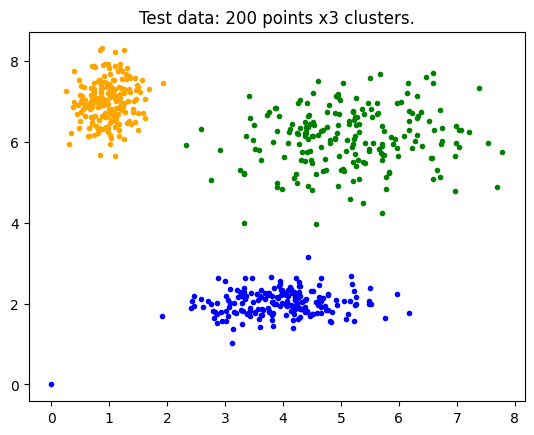

In [2]:
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

In [3]:
def mountain_clustering(points, sample_density=10, alpha=1.0, beta=0.5):
    threshold = np.sqrt(1 / (2 * beta))
    
    # Normalize the space
    p_min, p_max = points.T.min(axis=1, keepdims=True), points.T.max(axis=1, keepdims=True)
    points = ((points.T - p_min) / (p_max - p_min)).T

    # Sample candidates
    candidates = np.dstack(np.meshgrid(*map(lambda ax: np.linspace(0, 1, sample_density), range(points.shape[1])))).reshape(-1, points.shape[1])

    def dist(p1, p2):
        p1 = p1.reshape(-1, points.shape[1])
        return np.sum((p1 - p2) ** 2, axis=1)

    potentials = []
    centers = []
    max_potential = float('inf')

    # Generate intial potential distribution
    for i in range(candidates.shape[0]):
        potential = np.sum(np.exp(-alpha * dist(points, candidates[i])))
        potentials.append(potential)
    potentials = np.array(potentials)    

    # Select centers and adjust potentials until terminal condition is met
    while max_potential > threshold:
        candidate_id = np.argmax(potentials)
        center = candidates[candidate_id]
        centers.append(center)

        adjusted_potentials = []
        for i in range(candidates.shape[0]):
            potential = potentials[i] - potentials[candidate_id] * np.exp(-beta * dist(center, candidates[i]))
            adjusted_potentials.append(potential)
        potentials = np.array(adjusted_potentials)
        max_potential = np.max(potentials)
    
    centers = np.array(centers)
    centers = (centers * (p_max - p_min).T + p_min.T)
    return centers

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

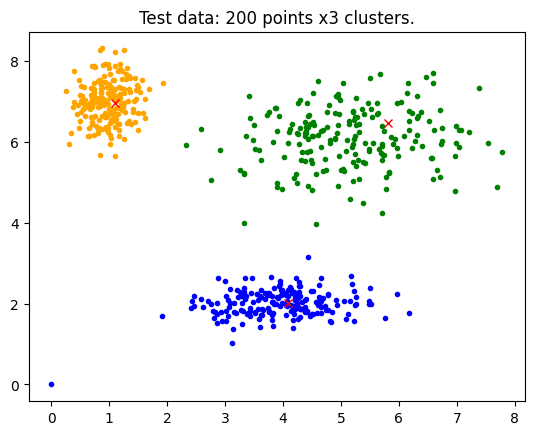

In [4]:
data = np.vstack((xpts, ypts)).T
centers = mountain_clustering(data, sample_density=100, alpha=15.0, beta=5.0)

# Visualize the test data
fig0, ax0 = plt.subplots()

for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
    
ax0.plot(centers[:, 0], centers[:, 1], 'x', color='r')
ax0.set_title('Test data: 200 points x3 clusters.')

In [5]:
def subtractive_clustering(points, influence=0.5, alpha=0.5):    
    # Normalize the space
    p_min, p_max = points.T.min(axis=1, keepdims=True), points.T.max(axis=1, keepdims=True)
    points = ((points.T - p_min) / (p_max - p_min)).T

    def dist(p1, p2):
        p1 = p1.reshape(-1, points.shape[1])
        return np.sum((p1 - p2) ** 2, axis=1)
    
    centers = [] 

    # Select centers and filter out (subtract) non-clustered points
    while points.shape[0] > 0:
        potentials = []

        for i in range(points.shape[0]):
            potential = np.sum(np.exp(-alpha * dist(points, points[i])))
            potentials.append(potential)
        potentials = np.array(potentials)

        candidate_id = np.argmax(potentials)
        center = points[candidate_id,:]
        centers.append(center)

        points = points[dist(points, center) > influence]
    
    centers = np.array(centers)
    centers = (centers * (p_max - p_min).T + p_min.T)
    return centers

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

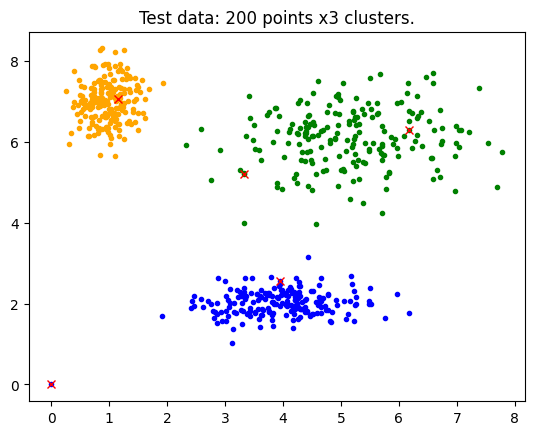

In [6]:
centers = subtractive_clustering(data, alpha=5.0, influence=0.1)

# Visualize the test data
fig0, ax0 = plt.subplots()

for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
    
ax0.plot(centers[:, 0], centers[:, 1], 'x', color='r')
ax0.set_title('Test data: 200 points x3 clusters.')